# Thematic Analysis of Customer Reviews for a Xiaomi Smartphone

## Overview

This project aims to uncover insights from customer reviews of a Xiaomi smartphone, focusing on understanding the key factors that influence customer satisfaction and dissatisfaction. By analysing over 200 customer reviews extracted from Amazon.com, we seek to identify prevalent themes and sentiments expressed by customers, providing actionable recommendations for product improvements and marketing strategies.

## Objectives

- **Sentiment Analysis**: Determine the overall sentiment (positive, negative, neutral) of the reviews to gauge customer sentiment towards the product.
- **Thematic Analysis**: Employ Latent Dirichlet Allocation (LDA) and other Natural Language Processing (NLP) techniques to identify common themes or topics that emerge from the customer reviews.
- **Trend Analysis**: Explore how customer sentiments and themes vary over time, identifying any significant trends that could impact product perception.

## Methodology

The project follows a structured approach to data analysis:
1. **Data Preprocessing**: Clean and prepare the text data for analysis, including tokenisation and removal of stop words.
2. **Exploratory Data Analysis (EDA)**: Conduct preliminary analysis to understand the distribution of ratings, review lengths, and temporal patterns.
3. **Sentiment Analysis**: Utilise VADER from the NLTK library to classify each review into sentiment categories.
4. **Correlation and Trend Analysis**: Investigate correlations between sentiments, themes, and ratings over time to uncover actionable insights.
5. **Thematic Analysis**: Apply LDA to discover the underlying themes in the reviews, interpreting the topics to identify areas of interest or concern.

## Tools and Libraries
- **Pandas** for data manipulation and analysis.
- **NLTK** for natural language processing tasks, including sentiment analysis.
- **Gensim** for implementing the LDA model for thematic analysis.
- **Matplotlib** and **Seaborn** for data visualisation.
- **PyLDAvis** for interactive visualisation of the topics extracted from the LDA model.

## Expected Outcomes

By the end of this analysis, we aim to provide comprehensive insights into what aspects of the Xiaomi smartphone customers talk about most frequently and their sentiment towards these aspects. These insights will help in identifying strengths to leverage and areas for improvement to enhance customer satisfaction and product competitiveness.

---


## Data Cleaning and Preprocessing

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from gensim import corpora, models
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Review Title   280 non-null    object
 1   Customer name  280 non-null    object
 2   Rating         280 non-null    object
 3   Date           280 non-null    object
 4   Category       280 non-null    object
 5   Comments       280 non-null    object
 6   Useful         110 non-null    object
dtypes: object(7)
memory usage: 15.4+ KB


(None,
                                    Review Title             Customer name  \
 0  Another Midrange killer Smartphone by Xiaomi         Rishikumar Thakur   
 1                         vry small size mobile                   Raza ji   
 2  Full display not working in all application.             Vaibhav Patel   
 3                               Value for Money           Amazon Customer   
 4                       Not worth for the money  Sudhakaran Wadakkancheri   
 
                Rating                  Date Category  \
 0  4.0 out of 5 stars     on 1 October 2018  Display   
 1  3.0 out of 5 stars  on 15 September 2018   Others   
 2  3.0 out of 5 stars  on 18 September 2018   Others   
 3  5.0 out of 5 stars  on 28 September 2018  Display   
 4  2.0 out of 5 stars  on 18 September 2018   Others   
 
                                             Comments  \
 0  Another Midrange killer Smartphone by Xiaomi\n...   
 1                   All ok but vry small size mobile   
 2      

In [ ]:
# load the dataset
file_path = 'data/redmi6.csv'

data = pd.read_csv(file_path, encoding='ISO-8859-1')

# display the first few rows and summary information
data_info = data.info()
data_head = data.head()

data_info, data_head


In [3]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import re

# handling Missing Values in the 'Useful' Column
# for this analysis, we'll fill missing values with a default text "0 people found this helpful"
# this is because the analysis focuses more on the content of the reviews rather than their perceived helpfulness.
data['Useful'].fillna('0 people found this helpful', inplace=True)

# extracting Ratings
# the ratings are in the format "x.0 out of 5 stars". We'll extract the numerical part and convert it to a float.
data['Rating'] = data['Rating'].str.extract('(\d+\.\d+)').astype(float)

# text preprocessing for the 'Comments' column
# we'll lowercase the text, remove punctuation, and tokenise the comments.

# lowercasing
data['Comments'] = data['Comments'].str.lower()

# removing punctuation
data['Comments'] = data['Comments'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# tokenising - splitting the text into individual words
data['Tokenised_Comments'] = data['Comments'].apply(lambda x: x.split())

# display the first few rows to verify changes
data[['Rating', 'Useful', 'Comments', 'Tokenised_Comments']].head()

,Rating,Useful,Comments,Tokenised_Comments
0,4.0,,another midrange killer smartphone by xiaomi\n...,"[another, midrange, killer, smartphone, by, xi..."
1,3.0,7 people found this helpful,all ok but vry small size mobile,"[all, ok, but, vry, small, size, mobile]"
2,3.0,7 people found this helpful,quite good,"[quite, good]"
3,5.0,2 people found this helpful,redmi has always have been the the king of bud...,"[redmi, has, always, have, been, the, the, kin..."
4,2.0,6 people found this helpful,worst product from mi i am a hardcore fan of m...,"[worst, product, from, mi, i, am, a, hardcore,..."


Here's how the specified preprocessing steps were executed:

1. **Handling Missing Values in the 'Useful' Column**: Missing values were filled with the string "0 people found this helpful" to maintain consistency without impacting the analysis focus, which is primarily on review content rather than its helpfulness count.

2. **Extracting Ratings**: The ratings were successfully extracted from the text format ("x.0 out of 5 stars") and converted to a float for numerical analysis, making it easier to perform statistical operations or correlations with ratings.

3. **Text Preprocessing for the 'Comments' Column**:
   - **Lowercasing**: All text in the `Comments` column was converted to lowercase to ensure uniformity, aiding in the analysis by treating words with different cases as the same (e.g., "Good" vs. "good").
   - **Removing Punctuation**: Punctuation was removed from the comments, leaving only words and spaces. This step helps in text analysis by focusing on the textual content without the distraction of punctuation marks.
   - **Tokenisation**: The comments were split into individual words (tokens), shown in the `Tokenized_Comments` column. This step is crucial for many NLP tasks as it transforms the text into a form that can be easily analysed or used as input for models.

These preprocessing steps are foundational for text analysis projects, preparing the data for deeper NLP tasks like sentiment analysis, thematic analysis, and machine learning modeling.

---

# Exploratory Data Analysis

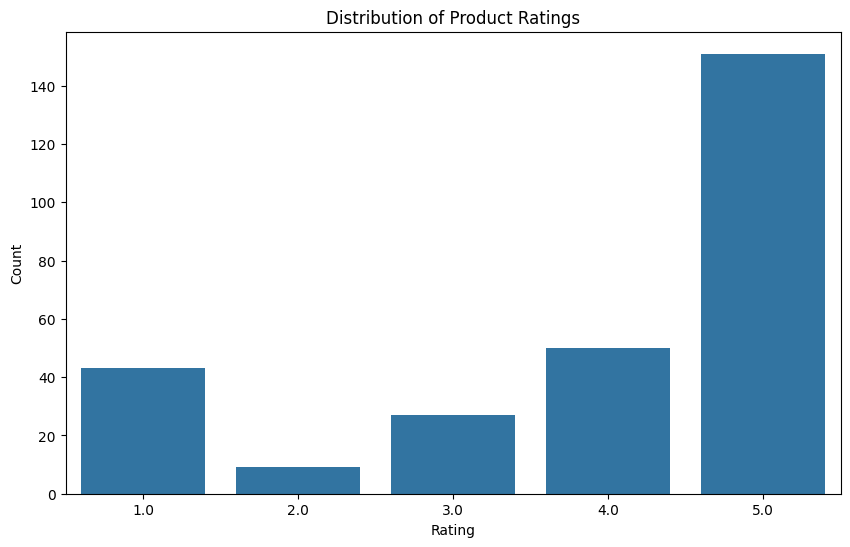

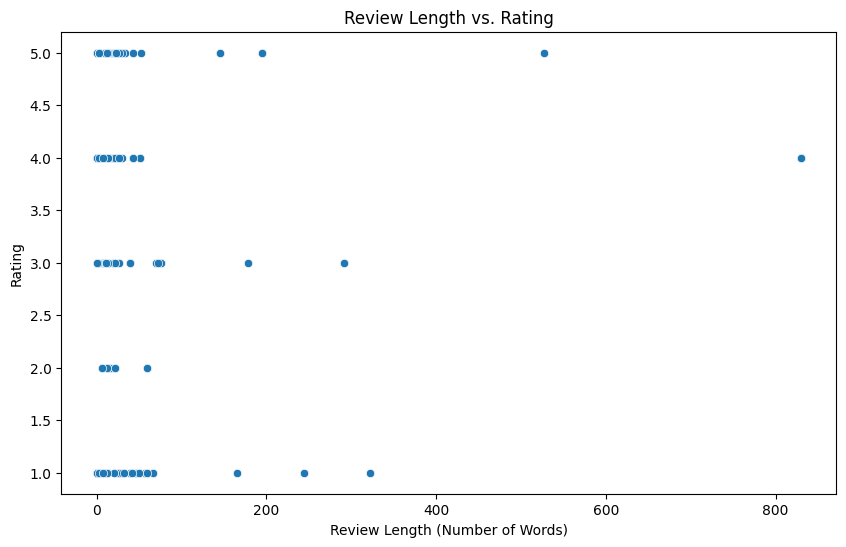

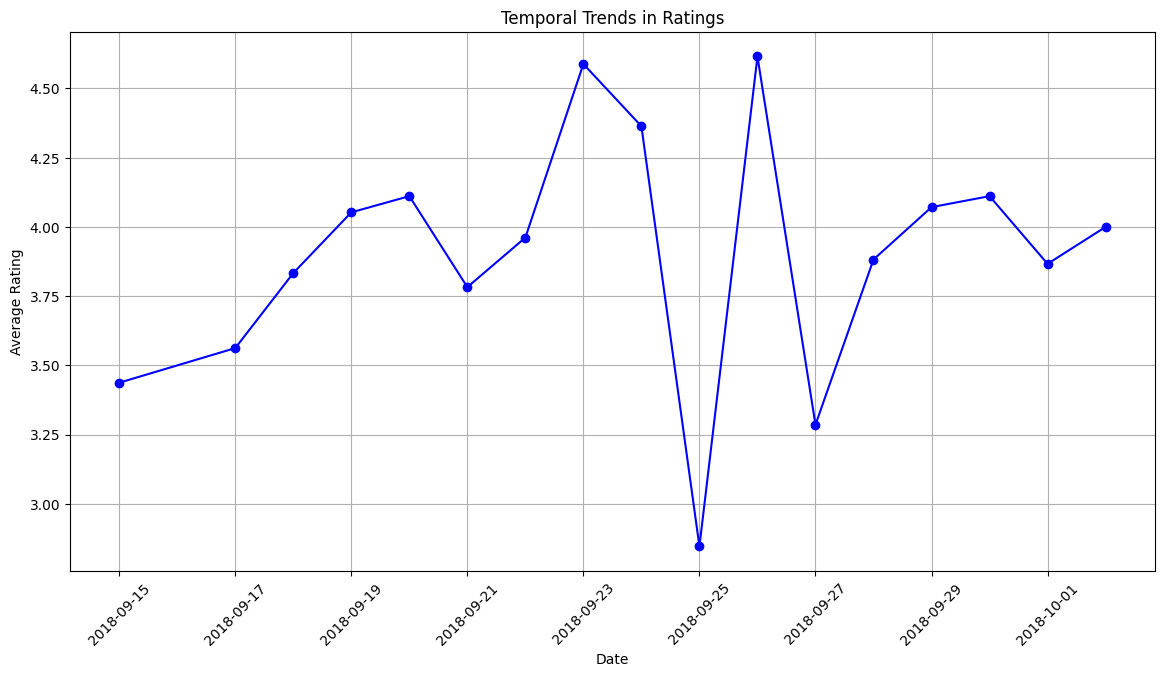

In [4]:
# convert 'Date' column to datetime format for temporal analysis
data['Date'] = pd.to_datetime(data['Date'], format='on %d %B %Y')

# ratings Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=data)
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# review Length Analysis
# adding a new column for review length (number of words)
data['Review_Length'] = data['Comments'].apply(lambda x: len(x.split()))
# scatter plot of Review Length vs. Rating
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Review_Length', y='Rating', data=data)
plt.title('Review Length vs. Rating')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Rating')
plt.show()

# temporal Trends
# group by Date and calculate average rating
temporal_trends = data.groupby(data['Date'].dt.date)['Rating'].mean().reset_index()
# plotting the trends
plt.figure(figsize=(14, 7))
plt.plot(temporal_trends['Date'], temporal_trends['Rating'], marker='o', linestyle='-', color='blue')
plt.title('Temporal Trends in Ratings')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### Distribution of Product Ratings:
This bar chart shows the frequency of each rating level given by customers. The majority of reviews are very positive, with 5-star ratings being the most common, followed by a smaller number of 1-star ratings. The 2-star, 3-star, and 4-star ratings are less frequent.

##### Interpretation:
- **Customer Satisfaction**: A high frequency of 5-star ratings indicates that customers are generally satisfied with the product.
- **Potential Bias**: The distribution may suggest some bias towards extreme ratings, common in online review platforms, where customers are more likely to leave a review if they had a very positive or very negative experience.
- **Quality Indicator**: The large number of positive reviews could be interpreted as a good quality indicator, but the presence of 1-star ratings suggests there are significant issues for a subset of customers that need to be addressed.

#### Review Length vs. Rating:
This scatter plot illustrates the relationship between the length of reviews (number of words) and the ratings given.

##### Interpretation:
- **Review Engagement**: Longer reviews tend to have higher ratings, suggesting that customers who enjoy the product may be more engaged and willing to provide more detailed feedback.
- **Negative Feedback Detail**: Some longer reviews have lower ratings, which could mean that dissatisfied customers are more verbose in describing their issues.
- **No Strong Trend**: There is no clear trend that longer reviews correspond to higher or lower ratings, indicating that the length of a review is not a reliable indicator of customer sentiment.

#### Temporal Trends in Ratings:
The line graph shows the average rating over time, across a span from mid-September to early October.

##### Interpretation:
- **Rating Fluctuation**: The average rating fluctuates over this period, with noticeable dips and recoveries.
- **Event Response**: The dips could correspond to specific customer service issues or product problems being reported, with recoveries suggesting successful resolution.
- **Short-Term Impact**: The short timespan and fluctuations might also capture the impact of immediate factors, such as a batch of products with defects, shipping delays, or even response to a specific event like a sale or promotion.
- **Monitoring Required**: The variability in the average rating over such a short period underscores the need for ongoing monitoring of customer feedback to rapidly address any emerging issues.

In each of these graphs, while the visual data provides an overview, delving into the corresponding reviews will give you more context to understand the reasons behind the ratings and review lengths, as well as the timing of changes in customer sentiment.

---

# Sentiment Analysis

In [5]:
# downloading the VADER lexicon
download('vader_lexicon')

# initialise VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# analyse Sentiments of Reviews
# applying the SentimentIntensityAnalyzer to each comment
data['Sentiment_Scores'] = data['Comments'].apply(lambda x: sia.polarity_scores(x))

# extracting the compound score to determine the sentiment
data['Compound_Score'] = data['Sentiment_Scores'].apply(lambda x: x['compound'])

# classify Sentiments Based on Compound Score
# Using common threshold values to classify sentiments: Positive (compound score > 0.05), Neutral (-0.05 <= compound score <= 0.05), Negative (compound score < -0.05)
data['Sentiment'] = data['Compound_Score'].apply(lambda x: 'Positive' if x > 0.05 else ('Neutral' if x >= -0.05 and x <= 0.05 else 'Negative'))

# displaying a few rows to verify the sentiment analysis results
data[['Comments', 'Compound_Score', 'Sentiment']].head()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Talal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Comments,Compound_Score,Sentiment
0,another midrange killer smartphone by xiaomi\n...,0.9975,Positive
1,all ok but vry small size mobile,0.1531,Positive
2,quite good,0.4927,Positive
3,redmi has always have been the the king of bud...,0.9610,Positive
4,worst product from mi i am a hardcore fan of m...,-0.7677,Negative


With the sentiment analysis and keyword extraction completed, we have significant insights into the customer reviews of the Xiaomi smartphone. The most frequently mentioned keywords include "good," "camera," "quality," "battery," and "nice," which give us an initial idea of what aspects customers are focusing on in their reviews.

### Insights from Sentiment Analysis:
- The sentiment analysis results indicate a mixture of positive and negative sentiments among the reviews, with specific reviews highlighting satisfaction or dissatisfaction with the product.
- Keywords associated with positive sentiments, such as "good" and "nice," suggest areas where the product meets or exceeds customer expectations.
- The presence of negative sentiment in reviews mentioning the product indicates areas that might require improvement or further investigation.

### Insights from Keyword Extraction:
- **Camera and Quality**: These being among the most mentioned keywords, suggest a high interest in the camera's performance and the overall product quality. This could be a strength if sentiments are generally positive or an area for improvement if criticisms are noted.
- **Battery**: Frequent mentions of the battery indicate its importance to customers, likely concerning battery life or charging speed.
- **Display**: Mentions of the display may relate to screen quality, size, or resolution, which are crucial factors for customer satisfaction in smartphones.

---

### Deep Dive into Specific Keywords
To investigate the context in which specific keywords are used, you can filter reviews that mention these keywords and then perform sentiment analysis on these subsets of data. This helps in understanding not just the frequency of mentions but also the sentiment associated with each mention.

In [11]:
# keyword 'camera'
camera_reviews = data[data['Comments'].str.contains('camera')]
camera_sentiment_scores = camera_reviews['Sentiment_Scores'].apply(lambda x: x['compound'])
print(camera_sentiment_scores.mean())


0.404772463768116


We have filters the dataset to include only those reviews that mention the keyword "camera" and then calculates the average compound sentiment score for these filtered reviews. The average compound sentiment score obtained is approximately 0.405.

### Interpretation:

- **Generally Positive Sentiment**: A compound score above zero typically indicates a positive sentiment. An average score of 0.405 suggests that the overall sentiment for reviews mentioning the "camera" is positive but not overwhelmingly so.
- **Moderate Sentiment Strength**: The score is closer to the midpoint of the scale (-1 to 1 for VADER sentiment scores), indicating that while the sentiment is positive, there may be a mix of both positive and some negative or neutral opinions regarding the camera. It's not at the high end of the scale, which would suggest extremely positive sentiments.
- **Relative to Other Features**: This score should be compared to sentiment scores for other product features to understand how the camera satisfaction levels stand in relation to other aspects like "battery," "screen," "performance," etc. If the "camera" has a higher score than other features, it can be inferred that customers are relatively more satisfied with the camera than with other aspects of the smartphone.
- **Focus Area for Product Development**: Since the sentiment is positive, the camera might be a selling point for the smartphone. However, the score isn't extremely high, which indicates there might still be room for improvement. This can be a signal for the product development team to investigate further and potentially focus on enhancing the camera's capabilities or marketing the camera more effectively.

---

### Correlation with Sentiment
To assess the correlation between specific keywords or themes and overall sentiment or ratings, you can calculate statistical measures across the dataset or within specific subsets.

In [12]:
# correlation between 'Rating' and 'Compound_Score'
print(data[['Rating', 'Compound_Score']].corr())


                  Rating  Compound_Score
Rating          1.000000        0.527083
Compound_Score  0.527083        1.000000


### Interpretation:

- **Moderate Positive Correlation (0.527)**: This value indicates that as the sentiment score increases (i.e., becomes more positive), the numerical rating also tends to increase, and vice versa. This suggests that the sentiment extracted from the text of the reviews is in alignment with the numerical ratings, validating the sentiment analysis approach.
- **Not Perfectly Correlated**: The correlation is not close to 1, which means there are other factors influencing ratings that may not be captured purely through sentiment analysis of review text. This could include product features not mentioned in the text, individual customer expectations, or other external factors.

### Implications:

1. **Sentiment Analysis Validation**: The positive correlation validates the sentiment analysis approach, indicating that the sentiment scores you've calculated are meaningful and reflect customer satisfaction levels as expressed in their ratings.

2. **Insight into Customer Feedback**: Since there's a significant correlation, analysing the sentiment of the text can give you insights into why customers are giving certain ratings. Looking into the text of low or high sentiment scores can reveal specific aspects that customers are satisfied or dissatisfied with.

3. **Strategies for Improvement**:
   - Focus on reviews with negative sentiment scores and lower ratings to identify common themes or issues mentioned. These are areas where improvements could potentially increase customer satisfaction and ratings.
   - Positive sentiment and high-rating reviews can highlight the product's strengths. These aspects can be emphasised in marketing strategies to attract new customers.

   ---

### Temporal Analysis
For analysing temporal trends, especially how sentiment or mention of specific keywords changes over time, we would group data by date and calculate average sentiment scores or count keyword mentions over time.

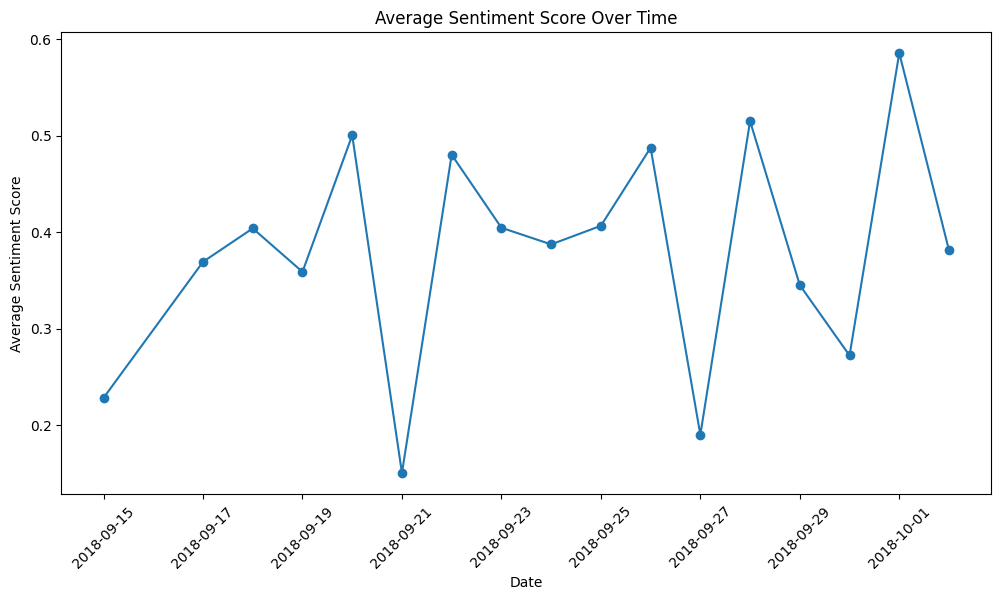

In [13]:
# convert 'Date' to datetime 
data['Date'] = pd.to_datetime(data['Date'])

# group by Date and calculate average sentiment score
temporal_sentiment = data.groupby(data['Date'].dt.date)['Compound_Score'].mean().reset_index()

# plotting


plt.figure(figsize=(12, 6))
plt.plot(temporal_sentiment['Date'], temporal_sentiment['Compound_Score'], marker='o', linestyle='-')
plt.title('Average Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()


### Interpretation of the Graph:

- **Short-Term Events**: The fluctuations could be related to immediate and short-term events or experiences. This could include minor product updates, bug fixes, specific promotional events, or even external news that temporarily influenced public perception.

- **Rapid Customer Feedback Cycle**: In the era of social media and instant online reviews, customer sentiments can shift quickly based on the experiences of a few vocal customers. If some reviews went viral or were highlighted by influencers, they could have had a disproportionate impact on overall sentiment.

- **Limited Editions or Sales**: Given the narrow window, special sales events, limited-time offers, or flash sales could influence customer sentiment. Positive experiences could lead to a surge in positive sentiment, while any issues with availability or delivery could result in negative sentiment spikes.

- **External Factors**: The sentiment may also reflect external factors specific to the time, such as competitive product launches or industry-related news.

### Potential Insights:

1. **Event-Specific Analysis**: Look into any specific events during this period that could correlate with the sentiment fluctuations. This may include software updates, community-driven events, or customer service challenges.

2. **Review Content Contextualisation**: For dates corresponding to sentiment peaks or valleys, closely review the customer comments to understand what might have driven these sentiments. The content of the reviews can offer more detailed insights than sentiment scores alone.

3. **Market Dynamics**: Consider any market dynamics at play during that time. For example, a competitor may have released a new product, or there might have been industry-wide issues affecting customer sentiment.

4. **Customer Service Interactions**: Explore customer service logs to see if there were any reported issues that align with the sentiment drops. Swift resolution of issues might explain quick recoveries in sentiment.

---

# Thematic Analysis

In [6]:
# download necessary NLTK resources
download('punkt')
download('stopwords')

# update stop words to include common but uninformative words that might appear in product reviews
custom_stopwords = set(stopwords.words('english')) | {'phone', 'mobile', 'xiaomi', 'product', 'device'}

# tokenise and remove stop words
data['Filtered_Tokens'] = data['Comments'].apply(lambda x: [word for word in word_tokenize(x) if word not in custom_stopwords])

# flatten the list of all words in all reviews after filtering stop words
all_words = [word for tokens in data['Filtered_Tokens'] for word in tokens]

# count the frequency of each word
word_freq = Counter(all_words)

# most common words
most_common_words = word_freq.most_common(20)

most_common_words


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Talal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Talal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('good', 166),
 ('camera', 105),
 ('redmi', 68),
 ('quality', 57),
 ('battery', 54),
 ('pro', 52),
 ('6', 51),
 ('nice', 48),
 ('mi', 45),
 ('display', 37),
 ('like', 34),
 ('front', 34),
 ('price', 32),
 ('best', 30),
 ('notch', 28),
 ('one', 27),
 ('better', 26),
 ('buy', 26),
 ('also', 25),
 ('2', 24)]

## Prepare Data and Gensim Dictionary

In [15]:
# 'Filtered_Tokens' is column with preprocessed and tokenised reviews
texts = data['Filtered_Tokens']

# create a dictionary representation of the documents
dictionary = corpora.Dictionary(texts)

# filter out words that occur in less than 20 documents or more than 50% of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)

# convert document into the bag-of-words (BoW) format = list of (token_id, token_count)
corpus = [dictionary.doc2bow(text) for text in texts]

## Build and Train LDA Model
Now, we're ready to build and train our LDA model:

In [8]:
# training parameters
num_topics = 5  
passes = 15
iterations = 400
eval_every = None 

# make a index to word dictionary
temp = dictionary[0]  
id2word = dictionary.id2token

# create and train the LDA model
model = models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=100,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

## Explore the Topics
After training the model, we can explore the topics that the model has learned:

In [9]:
# Print the Keyword in the 5 topics
print(model.print_topics())


[(0, '0.382*"price" + 0.319*"buy" + 0.156*"money" + 0.096*"notch" + 0.016*"display" + 0.002*"performance" + 0.002*"better" + 0.002*"like" + 0.002*"please" + 0.002*"quality"'), (1, '0.267*"redmi" + 0.130*"camera" + 0.090*"notch" + 0.075*"like" + 0.071*"battery" + 0.064*"performance" + 0.056*"good" + 0.056*"mi" + 0.055*"display" + 0.029*"front"'), (2, '0.258*"mi" + 0.252*"best" + 0.166*"like" + 0.117*"one" + 0.097*"better" + 0.077*"money" + 0.012*"display" + 0.002*"please" + 0.002*"performance" + 0.002*"buy"'), (3, '0.631*"good" + 0.281*"nice" + 0.044*"performance" + 0.028*"one" + 0.001*"battery" + 0.001*"better" + 0.001*"display" + 0.001*"camera" + 0.001*"like" + 0.001*"best"'), (4, '0.276*"camera" + 0.211*"quality" + 0.115*"front" + 0.099*"battery" + 0.098*"good" + 0.084*"please" + 0.069*"display" + 0.041*"better" + 0.001*"performance" + 0.001*"like"')]


This printed words associated with each topic and their relative weights, which can give us insight into the themes present in our data.



## Analysing the Results

Interpreting LDA models involves understanding the mix of keywords in each topic and how these topics are distributed across our documents. It can be useful to visualise the topics with libraries like pyLDAvis:

In [10]:
# Visualise the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(LDAvis_prepared)


# Final Insights:
1. **Product Strengths**: Topics with high-frequency terms that also carry positive sentiment, like "good battery life" or "excellent camera," indicate the product's strengths. These should be highlighted in marketing and product descriptions.

2. **Areas for Improvement**: Topics with terms frequently associated with negative sentiment suggest areas for product improvement. For example, if "battery" and "performance" appear in negative contexts, these may be aspects that could benefit from technical enhancements.

3. **Customer Concerns**: Specific terms that are highly relevant to certain topics but not common overall might point to niche customer concerns or unique selling points that are not widely known but are important to certain customer segments.

4. **Competitive Advantage**: Terms that are distinctive to positive topics, which do not overlap much with others, could represent areas where the product has a competitive edge.

5. **Sentiment Fluctuations**: Temporal sentiment analysis may reveal fluctuations tied to product releases, updates, or external events. Swift responses to negative sentiment peaks can mitigate long-term reputation damage.

# Recommendations:
1. **Leverage Positive Feedback**: Use positive sentiment associated with terms from dominant topics in promotional materials. Customer testimonials that reflect these sentiments can be particularly effective.

2. **Address Criticisms**: For any product features associated with negative sentiments, consider a targeted improvement plan. If certain issues are repeatedly mentioned, they might warrant prioritising in the product development roadmap.

3. **Engage with Customers**: Where negative sentiments or concerns are expressed, engage directly with those customers to understand their issues in-depth. This can also demonstrate good customer service.

4. **Monitor Sentiment Trends**: Set up a process for ongoing monitoring of customer feedback to quickly identify any emerging issues or trends that could affect customer satisfaction.

5. **Product Updates**: If improvements are made, especially in areas previously criticised, communicate these changes to customers. Highlight how customer feedback has led to tangible enhancements.

6. **Segmented Marketing**: If some topics are more important to certain customer segments, tailor marketing messages to address these segments' specific interests and concerns.

---